In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import namedtuple
import os

from utils import generate_run_id

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

import opacus
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator

# Random Seeding
torch.manual_seed(0)
np.random.seed(0)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Given parameter clip bounds c_p, compute maximal ReLU activation bounds B_sigma
def compute_ReLU_bounds(model, c_p, input_size=(784,), input_bounds=1.0, B_sigma_p=1.0):
    sample = torch.ones(image_size ** 2).to(device) * input_bounds
    B_sigma = 0.0
    sum_mk_mkp1 = 0
    skip_first = True

    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            W = torch.ones_like(layer.weight) * c_p
            sample = W @ sample
            
            B_sigma = max(B_sigma, sample.max().detach().item())
            
            if skip_first:
                skip_first = False
            else:
                sum_mk_mkp1 += W.shape[0] * W.shape[1]
                # sum_mk_mkp1 += (W.shape[0] + 1) * (W.shape[1] + 1)
            # print(layer.weight.shape, B_sigma, sample.max().detach().item(), sum_mk_mkp1, W.shape[0], W.shape[1])
    print("B_sigma", B_sigma)
    print("sum_mk_mkp1", sum_mk_mkp1)
    
    c_g = 2 * c_p * B_sigma * (B_sigma_p ** 2) * sum_mk_mkp1
    return c_g

In [6]:
# Collect all parameters
Args = namedtuple('Args', [
    'hidden', 'nz', 'ngf', 'nc', 'epsilon', 'delta', 'noise_multiplier', 
    'c_p', 'lr', 'beta1', 'batch_size', 'n_d', 'n_g'
])

# n_d: number of discriminator updates per generator update
# n_g: number of generator updates
# args = Args(
#     # Model Parameters
#     hidden=[64, 16], nz=100, ngf=32, nc=1, 
#     # Privacy Parameters
#     epsilon=50.0, delta=1e-6, noise_multiplier=0.1, c_p=0.01, 
#     # Training Parameters
#     lr=1e-3, beta1=0.5, batch_size=32, n_d=3, n_g=int(1e4)
# )

args = Args(
    # Model Parameters
    hidden=[16, 12], nz=100, ngf=32, nc=1, 
    # Privacy Parameters
    epsilon=50.0, delta=1e-6, noise_multiplier=0.3, c_p=0.01, 
    # Training Parameters
    lr=1e-3, beta1=0.5, batch_size=16, n_d=3, n_g=int(1e4)
)

# Generate Run ID
run_id = generate_run_id(args)

# Create Folder Path
run_fp = os.path.join('runs/', run_id)
os.makedirs(run_fp, exist_ok=True)
run_fp

'runs/16-12_100_32_1_50.0_1e-06_0.25_0.01_0.001_0.5_32_3_10000'

In [7]:
# Setup models
netD = Discriminator(args.hidden[0], args.hidden[1]).to(device)
netG = Generator(args.nz, args.ngf, args.nc).to(device)
netG.apply(weights_init)

# Privacy Validation
ModuleValidator.validate(netD, strict=True)

# Setup parameters for Gradient Clip Calculation
c_g = compute_ReLU_bounds(netD, args.c_p)
print("Gradient clip:", c_g)

# Setup optimizers
optimizerD = optim.Adam(netD.parameters(), lr=args.lr, betas=(args.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=args.lr, betas=(args.beta1, 0.999))

# Setup loss
loss_fn = nn.BCEWithLogitsLoss()

B_sigma 7.840000152587891
sum_mk_mkp1 204
Gradient clip: 31.987200622558593


In [8]:
# Setup MNIST dataset
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=4)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=4)

M = len(train_set)

# sample_prob = batch_size / M
# print("Sample Probability:", sample_prob)

In [9]:
privacy_engine = PrivacyEngine()
print(
    f"Before make_private(). "
    f"Model:{type(netD)}, \nOptimizer:{type(optimizerD)}, \nDataLoader:{type(train_loader)}"
)
netD, optimizerD, train_loader = privacy_engine.make_private(
    module=netD,
    optimizer=optimizerD,
    data_loader=train_loader,
    max_grad_norm=c_g,
    noise_multiplier=args.noise_multiplier,
)
print("="*20)
print(
    f"After make_private(). "
    f"Model:{type(netD)}, \nOptimizer:{type(optimizerD)}, \nDataLoader:{type(train_loader)}"
)

Before make_private(). Model:<class '__main__.Discriminator'>, 
Optimizer:<class 'torch.optim.adam.Adam'>, 
DataLoader:<class 'torch.utils.data.dataloader.DataLoader'>
After make_private(). Model:<class 'opacus.grad_sample.grad_sample_module.GradSampleModule'>, 
Optimizer:<class 'opacus.optimizers.optimizer.DPOptimizer'>, 
DataLoader:<class 'opacus.data_loader.DPDataLoader'>


/home/jason/.pyenv/versions/3.8.0/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [2]:
def train(run_fp, args, netD, netG, optimizerD, optimizerG, loss_fn, train_loader, device, verbose=False):
    netD.train()
    netG.train()

    print_mod = 10

    with open(f"{run_fp}/loss.txt", "a") as f:
        for i in tqdm(range(args.n_g)):
            # Update Discriminator
            netD.enable_hooks()
            netD.train()
            netG.eval()
            for j in range(args.n_d):
                # Train with real data
                real_data = next(iter(train_loader))[0].to(device)
                real_data = real_data.view(real_data.size(0), -1)
                
                # Train with fake data
                noise = torch.randn(real_data.size(0), 100, 1, 1).to(device)
                fake_data = netG(noise)

                # Run Discriminator
                real_output = netD(real_data)
                fake_output = netD(fake_data)

                # Calculate loss (Wasserstein Loss)
                d_loss = -torch.mean(real_output) + torch.mean(fake_output)

                # real_label = torch.ones(real_data.size(0), 1).to(device)
                # fake_label = torch.zeros(real_data.size(0), 1).to(device)

                # Update Discriminator
                # real_loss = loss_fn(real_output, real_label)
                # fake_loss = loss_fn(fake_output, fake_label)
                # d_loss = real_loss + fake_loss

                optimizerD.zero_grad()
                d_loss.backward()
                optimizerD.step()

                # Clip weights in discriminator
                for p in netD.parameters():
                    p.data.clamp_(-args.c_p, args.c_p)

                if verbose:
                    print(f"Epoch: {i} ({j}/{args.n_d}) D_loss: {d_loss.item()} eps: {privacy_engine.get_epsilon(args.delta)}")
                if i % print_mod == 0:
                    print(f"{i}.{j}, {d_loss.item()}, {privacy_engine.get_epsilon(args.delta)}", file=f)

            # Make a copy of the discriminator
            # copy_dict = netD.state_dict()
            # copy_dict = {k.replace('_module.', ''): v for k, v in copy_dict.items()}
            # netD_copy.load_state_dict(copy_dict)

            netD.eval()
            # for p in netD.parameters():
            #     p.requires_grad = False
            netD.disable_hooks()
            netG.train()

            # Update Generator
            noise = torch.randn(args.batch_size, 100, 1, 1).to(device)
            fake_data = netG(noise)
            # fake_output = netD_copy(fake_data)
            fake_output = netD(fake_data)
            fake_target = torch.ones(args.batch_size, 1).to(device)
            g_loss = loss_fn(fake_output, fake_target)

            # Update Generator
            optimizerG.zero_grad()
            g_loss.backward()
            optimizerG.step()

            if verbose:
                print(f"Epoch: {i} G_loss: {g_loss.item()}")
            if i % print_mod == 0:
                print(f"{i}, {g_loss.item()}", file=f)

            if (i+1) % 2000 == 0:
                torch.save(netG.state_dict(), f"{run_fp}/netG_{i+1}.pt")
                torch.save(netD._module.state_dict(), f"{run_fp}/netD_{i+1}.pt")

                # Save the model
                torch.save(privacy_engine.accountant, f"{run_fp}/accountant_{i+1}.pth")
                torch.save(optimizerD.original_optimizer.state_dict(), f"{run_fp}/optimizerD_{i+1}.pth")


In [3]:
# Create empty loss file
with open(f"{run_fp}/loss.txt", "w") as f:
    pass

train(run_fp, args, netD, netG, optimizerD, optimizerG, loss_fn, train_loader, device, verbose=True)

NameError: name 'run_fp' is not defined

In [ ]:
aaaaa

NameError: name 'aaaaa' is not defined

In [ ]:
!ls -lt *.pth
# !rm *.pth

ls: cannot access '*.pth': No such file or directory


In [ ]:
# Load the generator
netG = Generator().to(device)

netG.load_state_dict(torch.load("first_attempt/netG_49999.pt"))
netG.eval()


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [ ]:
# Generate Sample Images
noise = torch.randn(64, 100, 1, 1).to(device)
fake_data = netG(noise)
fake_data.shape

torch.Size([64, 1, 28, 28])

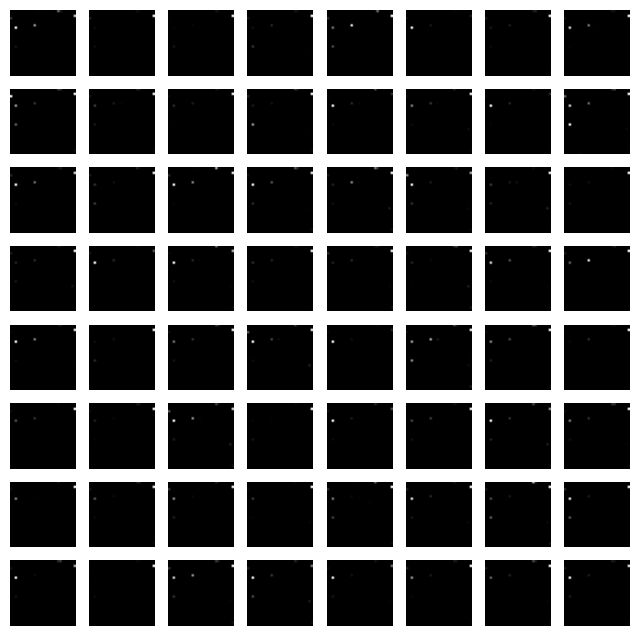

In [ ]:

# Plot the images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(fake_data[i, 0].cpu().detach().numpy(), cmap="gray")
    axi.axis("off")

plt.show()


In [ ]:
# Load accountant
accountant = torch.load("accountant.pth")
accountant

In [ ]:
# Verification of gradient clipping
def param_grad_norm(model):
    gradient_norm = 0
    for param in model.parameters():
        gradient_norm += torch.sum(param.grad ** 2)
    gradient_norm = gradient_norm ** 0.5
    return gradient_norm

def param_grad_l1(model):
    gradient_norm = 0
    for param in model.parameters():
        gradient_norm += param.grad.abs().sum().item()
    return gradient_norm

model = netD
optimizer = optimizerD
    
max_norm = 0
first = True
epsilon = 1e-7
c_p = 0.01
for idx in range(1000):
    if first:
        fill_val = c_p
        model.fc1.weight.data.fill_(fill_val)
        model.fc2.weight.data.fill_(fill_val)
        model.fc3.weight.data.fill_(fill_val)
        first = False
    else:
        # Randomize model weights (clip to c_p)
        model.fc1.weight.data = torch.clamp(torch.randn_like(model.fc1.weight), -c_p, c_p)
        model.fc2.weight.data = torch.clamp(torch.randn_like(model.fc2.weight), -c_p, c_p)
        model.fc3.weight.data = torch.clamp(torch.randn_like(model.fc3.weight), -c_p, c_p)
    
    # Print min max of model weights
    assert model.fc1.weight.min().item() >= -c_p - epsilon
    assert model.fc1.weight.max().item() <= c_p + epsilon
    assert model.fc2.weight.min().item() >= -c_p - epsilon
    assert model.fc2.weight.max().item() <= c_p + epsilon
    assert model.fc3.weight.min().item() >= -c_p - epsilon
    assert model.fc3.weight.max().item() <= c_p + epsilon
    
    for c in range(2):
        optimizer.zero_grad()

        # random sample
        sample = (torch.rand(784) > 0.1).to(torch.float32).to(device)
        # sample = torch.ones(784).to(device)
        assert sample.min().item() >= 0.0
        assert sample.max().item() <= 1.0

        sample_out = model(sample)
        # print("Sample Out:", sample_out.shape)

        # Assert all activations are below B_sigma
        activated_1 = F.relu(model.fc1(sample))
        activated_2 = F.relu(model.fc2(activated_1))
        activated_3 = torch.sigmoid(model.fc3(activated_2))
        # assert activated_1.max().item() <= B_sigma
        # assert activated_2.max().item() <= B_sigma
        # assert activated_3.max().item() <= B_sigma
        
        target = torch.ones((1, 1)).to(device) * c

        loss = loss_fn(sample_out, target)
        loss.backward()

        grad_norm = param_grad_norm(model)
        # l1_norm = param_grad_l1(model)
        if grad_norm > max_norm:
            max_norm = grad_norm
            # print("New L1 Norm:", l1_norm, idx, c)
            print("New Max Norm:", max_norm, idx, c)
    # break
    if max_norm > c_g:
        print("Max Norm Exceeded")
        break

print("Max Norm:", max_norm)

New Max Norm: tensor(1.7089, device='cuda:0') 0 0
Max Norm: tensor(1.7089, device='cuda:0')
